## import

In [1]:
#importing libraries & packages

import pandas as pd
import numpy as np
import seaborn as sns
sns.set()
import matplotlib.pyplot as plt
%matplotlib inline
import pandas_profiling
import datetime
import re
import pprint
pp = pprint.PrettyPrinter(indent=4)
from collections import Counter
import copy
# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
raw_df = pd.read_csv('Animal_Control_Incidents.csv')

In [3]:
#preserving original df before making alterations
df = raw_df.copy()

## functions

In [4]:
#sns overlapping distplot
def comp_counts(cols, labels):
    sns.set(rc={'figure.figsize':(10, 5)})
    plt.xlim(-5,100)
    plt.title("times")
    for col, label in zip(cols, labels):
        sns.distplot(df[col].value_counts(), label=label, bins=40)
    plt.legend()
    plt.show();

In [5]:
#sns countplot loop
def plot_counts(cols):
    for i, col in enumerate(cols):
       # print(df[col].value_counts())
        plt.figure(i)
        sns.countplot(y=col, data=df);

In [6]:
def edit_replace(old_words, replacement_word):
    for word in old_words:
        df['color'] = df.color.apply(lambda x: x.replace(word, replacement_word))

In [7]:
## nevermind -but may try to fix later for more universal functions
#
# #     for old_word in old_words:
# #         try:
# #            data = data.apply(lambda x: x.astype(str).str.replace(old_word, replacement_word))
#         for old_word in old_words:
#            data = data.apply(lambda x: x.replace(old_word, replacement_word))
            
# #        except:
# #            data = data.str.replace(old_word, replacement_word)
#
# def replace_breed(old_words, replacement_word):
#     for word in old_words:
#         df['breed'] = df.breed.apply(lambda x: x.replace(word, replacement_word))
#         #for word in old_words:
#           #  data = data.apply(lambda x: x.replace(word, replacement_word))

In [8]:
# pretty blue/green seaborn correlation plot for categorical data
# (dummies the categorical data within function unless dummy arguement False)
def corr_plot(data, minv=-.3, maxv=.3, dummy=True):
    
    #increase minv and/or maxv if too monochromatic

    if dummy:
        # dummy categorical features
        col_list = list(data.select_dtypes(include=['object']).columns)

        # create dummies for categorical features
        data = pd.DataFrame(pd.get_dummies(data=data,columns=col_list
                       , prefix=col_list))
    sns.set(style="white")
    corr = data.corr()

    # mask the size of covariance matrix
    mask = np.zeros_like(corr, dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True

    f, ax = plt.subplots(figsize=(10, 10))

    sns.heatmap(corr, mask=mask
                ,annot=False, cmap="YlGnBu", vmin = minv, vmax=maxv, center=0,
                square=True, linewidths=.5,cbar_kws= {"shrink": .5} );
#     ax.invert_yaxis();
    
    #prevent the shrink of bottom row
    ax.set_ylim(len(data.columns), 0)

## cleaning/EDA

In [9]:
df.head()

,FILE NUMBER,INCIDENT DATE,INCIDENT TIME,DISPATCHED TIME,CALL TAKER,DISPATCHER,DISPATCHED OTHER,DISPATCHED SITUATION,ARRIVAL TIME,AVAILABLE TIME,...,CONDITION,TEMPERMENT,COLLAR,COLLAR COLOR,VACCINATION NUMBER,VACCINATION DATE,PET NAME,DISPOSITION,DISPOSITION DATE,DISPOSITION OFFICER
0,201639027,12/27/2016,15:30,16:06,UNKNOWN,JENNIFER G,0,D,16:17,16:38,...,FAIR,FRIENDLY,NYLON,RED,NaN,NaN,NaN,TRANS CAA,12/27/2016,FRANK S
1,201639044,12/28/2016,10:06,10:07,UNKNOWN,JENNIFER G,0,D,10:15,10:23,...,FAIR,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,RETURN TO WILD,12/28/2016,TRAVIS R
2,201639036,12/28/2016,09:03,09:03,UNKNOWN,JENNIFER G,0,D,09:27,09:45,...,EMACIATED,FRIENDLY,LEATHER,PINK,NaN,NaN,NaN,TRANS CAA,12/28/2016,ISAAC S
3,201639042,12/28/2016,09:46,10:24,UNKNOWN,JENNIFER G,0,D,10:35,10:47,...,EMACIATED,FRIENDLY,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,JOHN B
4,201639059,12/28/2016,15:05,15:45,UNKNOWN,JENNIFER G,0,D,16:07,16:25,...,EMACIATED,NORMAL,UNKNOWN,UNKNOWN,NaN,NaN,NaN,TRANS CAA,12/28/2016,SUE H


In [10]:
# removing spaces and lower casing the column names
df.columns = df.columns.str.lower()
df.columns = df.columns.str.strip()
df.columns = df.columns.str.replace(' ', '_')

In [11]:
# df = df.apply(lambda x: x.astype(str).str.lower())
# df = df.apply(lambda x: x.astype(str).str.strip())
# #df = df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [12]:
#list of features with percent 'na'
round(df.isna().sum()/len(df)*100)

file_number               0.0
incident_date             0.0
incident_time             1.0
dispatched_time          15.0
call_taker               28.0
dispatcher               18.0
dispatched_other          0.0
dispatched_situation     15.0
arrival_time             16.0
available_time           15.0
complainant_street        0.0
request_type             45.0
officer                  16.0
equipment_number         18.0
remarks                  97.0
impound_number           28.0
impound_date             28.0
impound_time             28.0
location                 28.0
municipality             28.0
zip_code                 67.0
service_code             28.0
species                  28.0
breed                    29.0
sex                      45.0
size                     29.0
color                    29.0
age                      55.0
condition                31.0
temperment               30.0
collar                   66.0
collar_color             67.0
vaccination_number       99.0
vaccinatio

In [13]:
 #removing nas from incident time since such little nas
df = df[df['incident_time'].notna()]

### datetime conversion

Dates are 7 full years 2012-2018, times run between 5:22 to 9:9(which isn't a valid time)

__Converting times to datetime format:__

In [16]:
# time columns to list
time_cols= [col for col in df.columns if 'time' in col]

In [17]:
# covert time to hour/minute datetime format, errors = NaT
for col in time_cols:
    df[col] = pd.to_datetime(df[col], errors='coerce', format="%H:%M").dt.time

In [ ]:
print('Time Range:\n''from',df.incident_time.min(),'\n to:', df.incident_time.max())

In [18]:
df = df.sort_values(by= 'incident_time')

__Converting dates to datetime format:__

In [19]:
# all date columns to list
date_cols= [col for col in df.columns if 'date' in col]

In [20]:
## samples of date values
# for col in date_cols:
#     print(df[col].head())

In [21]:
# covert to month/day/year datetime format, errors= NaT
for col in date_cols:
    df[col] = pd.to_datetime(df[col],errors='coerce', format="%m/%d/%Y")

In [ ]:
print('Incident Dates:\n''from:',df.incident_date.min(),'\n to:', df.incident_date.max())

In [22]:
df = df.sort_values(by='incident_date')

In [23]:
# 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 72818 entries, 60519 to 73291
Data columns (total 38 columns):
file_number             72818 non-null int64
incident_date           72818 non-null datetime64[ns]
incident_time           72818 non-null object
dispatched_time         62546 non-null object
call_taker              52959 non-null object
dispatcher              60157 non-null object
dispatched_other        72818 non-null int64
dispatched_situation    62537 non-null object
arrival_time            61843 non-null object
available_time          62544 non-null object
complainant_street      72808 non-null object
request_type            40141 non-null object
officer                 60771 non-null object
equipment_number        59926 non-null object
remarks                 2024 non-null object
impound_number          52625 non-null float64
impound_date            52620 non-null datetime64[ns]
impound_time            51897 non-null object
location                52389 non-null object

In [24]:
pandas_profiling.ProfileReport(df)

Number of variables,39
Number of observations,72818
Total Missing (%),33.9%
Total size in memory,21.7 MiB
Average record size in memory,312.0 B
Numeric,5
Categorical,29
Boolean,1
Date,3
Text (Unique),0
Rejected,1


In [25]:
# observations from pandas profile report:

# - lots of columns missing data

# irrelevant columns:
# - ARRIVAL TIME- has most at 00:00
# - AVAILABLE TIME- most at 00:00
# - CALL TAKER
# - COLLAR
# - COLLAR COLOR
# - IMPOUND NUMBER
# - INCIDENT TIME
# - PET NAME
# - REMARKS(too little data provided(3%), existing data doesn't appear to be useful)
# - VACCINATION DATE(99.5% missing)
# - VACCINATION NUMBER
# - ZIP CODE


# columns needing work or consider exclusion:
# - AGE 55% missing
# - X in front of BREED- cross breed?
# - CONDITION 31% missing
# - DISPATCHED OTHER and DISPATCHED SITUATION- what does it mean?
# - EQUIPMENT NUMBER - what does it mean?
# - FILE NUMBER - not unique, is referring to same animal?
# - REQUEST TYPE and SERVICE CODE appear to provide same content
# - SEX contains only 37% M or F, other data missing or irregular
# - SIZE 30% missing
# - SPECIES 28% missing
# - TEMPERMENT 30% missing
# - COLOR 29% missing
# - LOCATION and COMPLAINT STREET can be merged?


In [26]:
df.drop_duplicates(keep=False, inplace=True)

In [27]:
# creating column that fills in missing values from service code using existing values from request type
df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

In [28]:
# dropping unneeded columns
df.drop(columns=['file_number', 'service_code', 'request_type'], inplace=True)

In [29]:
# creating day of week column:
df['weekday'] = pd.to_datetime(df['incident_date']).apply(lambda x: x.weekday())

In [30]:
df.weekday.value_counts()
# monday=0

0    15960
1    14032
2    13513
3    13072
4    11984
5     2149
6     1740
Name: weekday, dtype: int64

### missing data & exclusion

In [31]:
# preserving data to include na data
pre_drop_df= copy.deepcopy(df)
pre_drop_df = pre_drop_df.apply(lambda x: x.astype(str).str.lower())
pre_drop_df = pre_drop_df.apply(lambda x: x.astype(str).str.strip())
pre_drop_df = pre_drop_df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [32]:
#percent missing values per column
round(df.isna().sum()/len(df)*100)

incident_date             0.0
incident_time             0.0
dispatched_time          14.0
call_taker               27.0
dispatcher               17.0
dispatched_other          0.0
dispatched_situation     14.0
arrival_time             15.0
available_time           14.0
complainant_street        0.0
officer                  17.0
equipment_number         17.0
remarks                  97.0
impound_number           28.0
impound_date             28.0
impound_time             29.0
location                 28.0
municipality             28.0
zip_code                 67.0
species                  28.0
breed                    29.0
sex                      45.0
size                     30.0
color                    30.0
age                      55.0
condition                31.0
temperment               30.0
collar                   66.0
collar_color             66.0
vaccination_number       99.0
vaccination_date        100.0
pet_name                 99.0
disposition              28.0
dispositio

In [33]:
# removing columns with more than 1/3 missing data
#df.dropna(axis=1, thresh=(len(df)//1.5), inplace=True)

In [34]:
# check diff in value counts if dropna

# col_list = df.columns

# color_value_counts = df.color.value_counts()
# na_drop_color = (df.color.dropna()).value_counts()

## check difference of value counts if dropping all rows with nas:


# for column in col_list:
#    print (df[column].value_counts()/((df[column].dropna()).value_counts()))

In [35]:
#df = df.dropna(axis=0)

In [36]:
df = df.apply(lambda x: x.astype(str).str.lower())
df = df.apply(lambda x: x.astype(str).str.strip())
df = df.apply(lambda x: x.astype(str).str.replace(' ', '_'))

In [37]:
df.shape

(72450, 37)

### datetime features

There are 5 different time categories. Their descriptions are self descriptive, although the 'available time' wasn't clear at first. That category marks the time that the officer was finished with the incident and once again available

#### times

In [38]:
time_cols= [col for col in df.columns if 'time' in col]
time_cols

['incident_time',
 'dispatched_time',
 'arrival_time',
 'available_time',
 'impound_time']

In [39]:
for time in time_cols:    
    print(df[time].isna().sum())

0
0
0
0
0


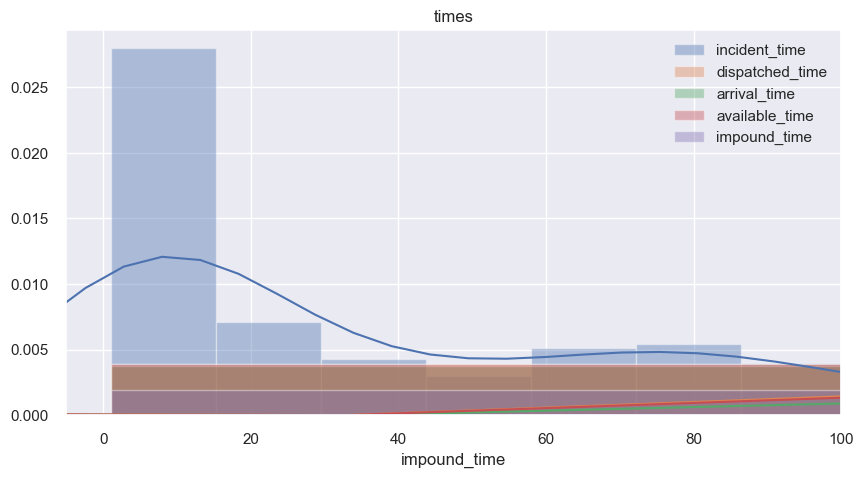

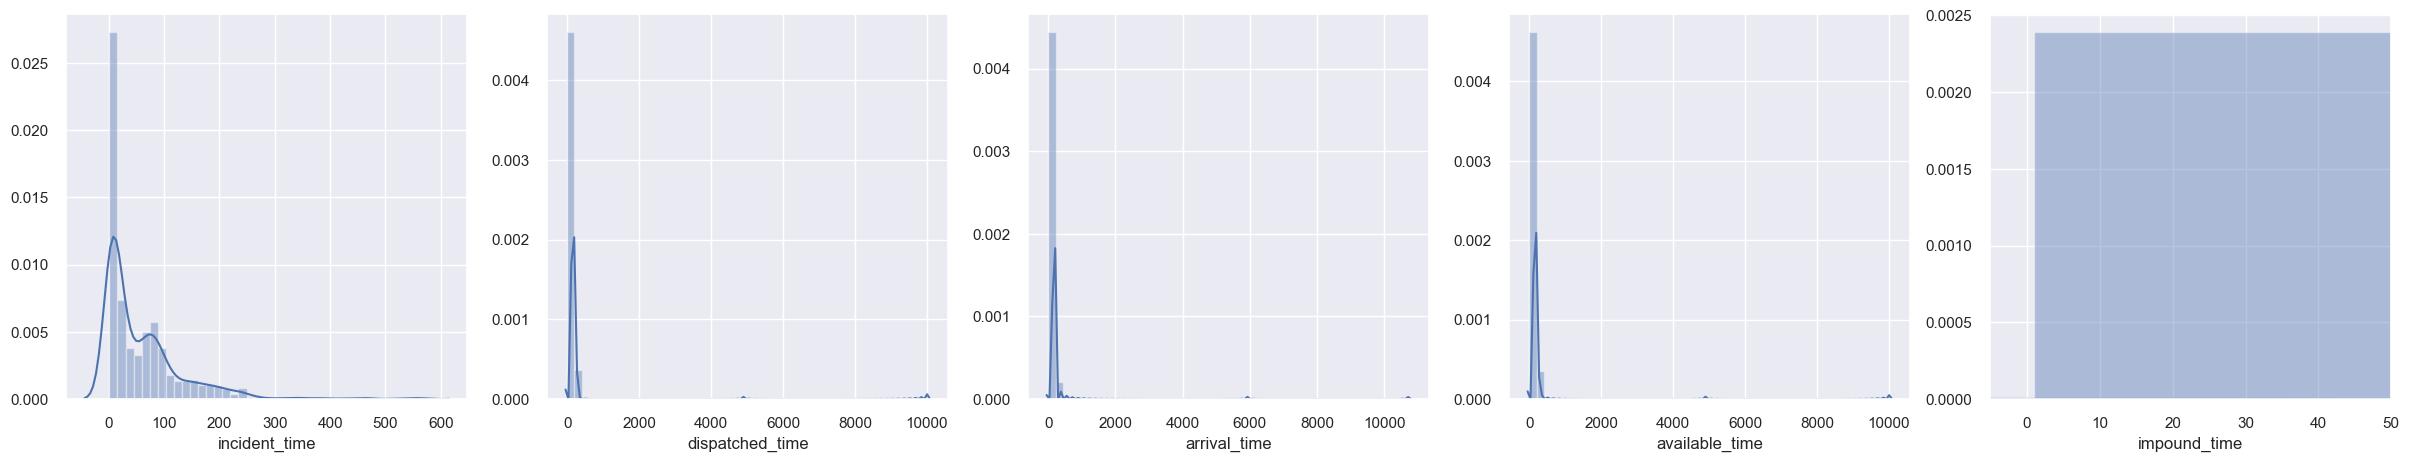

In [40]:
#comparing distribution of time features(**NEEDS WORK**)

comp_counts(time_cols, time_cols)

f, axes = plt.subplots(1, 5,figsize=(30,5))
plt.xlim(-5,50)

for col, ax in zip(time_cols,(range(0,5))):
    #df[col].value_counts().hist(bins=100, ax=axes[ax], color='darkblue')
    
    
    #df=df.dropna(axis=0)
    
    sns.distplot((df[col].dropna()).value_counts(), ax=axes[ax])
                #, bins=40)
   # plt.ylim(-5,50)
    
# sns.distplot(df['incident_time'].value_counts(), ax=axes[0], color='black', bins=40)

# sns.distplot(df['dispatched_time'].value_counts(), ax=axes[1], color='black',bins=40)

# sns.distplot(df['arrival_time'].value_counts(), ax=axes[2], color='black', bins=40)

# sns.distplot(df['available_time'].value_counts(), ax=axes[3], color='black', bins=40)

# sns.distplot(df['impound_time'].value_counts(), ax=axes[4], color='black', bins=40);

In [41]:
#sns.barplot(x = 'incident_time', y = df['incident_time'].value_counts().values, data = df, ci = None)
#sns.barplot(x=df.incident_time.value_counts().index, y=df.incident_time.value_counts())

In [42]:
#sns.countplot(x='incident_time', data=df);

#### dates

In [43]:
date_cols= [col for col in df.columns if 'date' in col]
date_cols

['incident_date', 'impound_date', 'vaccination_date', 'disposition_date']

/Users/Janelle/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/Janelle/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


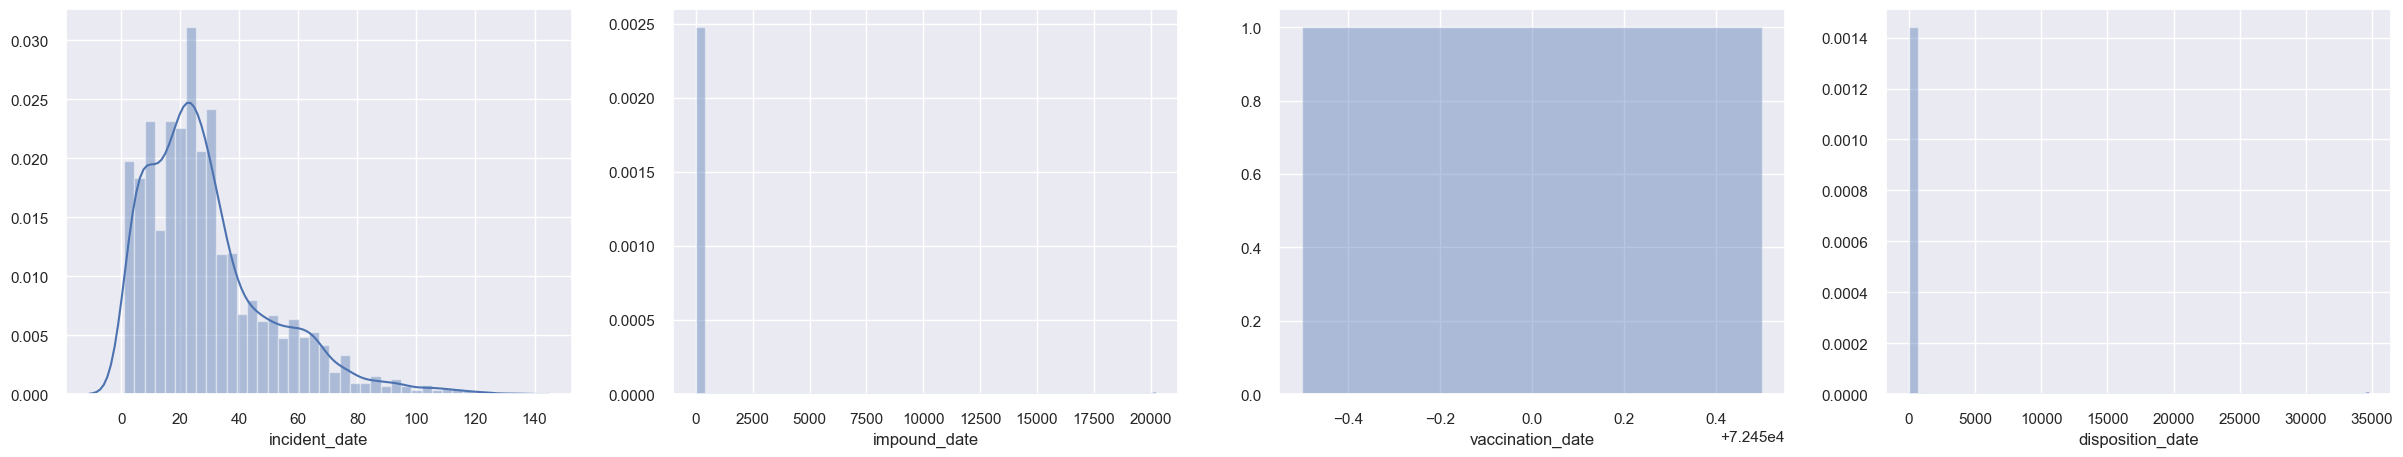

In [44]:
f, axes = plt.subplots(1, 4,figsize=(30,5))
for col, ax in zip(date_cols,(range(0,4))):
    sns.distplot((df[col].dropna()).value_counts(), ax=axes[ax])

In [45]:
# #comparing distribution of date features
# #comp_counts(date_cols, date_cols)

# sns.set(font_scale=1)

# f, axes = plt.subplots(1, 2,figsize=(15,3))
# sns.distplot(df['incident_date'].value_counts(), ax=axes[0], color='black', bins=40)
# sns.distplot(df['impound_date'].value_counts(), ax=axes[1], color='black', bins=40);
# #sns.distplot(df['disposition_date'].value_counts(), ax=axes[2], color='black', bins=40);

### names

In [46]:
name_cols = ('call_taker', 'dispatcher', 'officer', 'disposition_officer') 

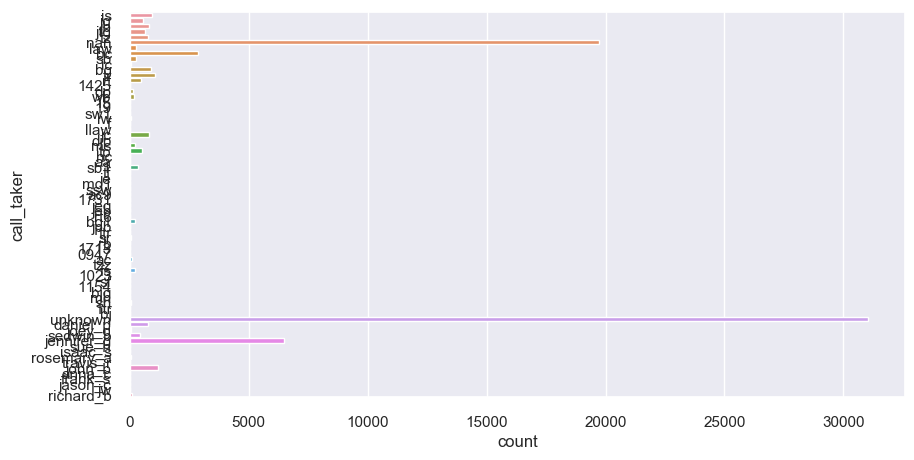

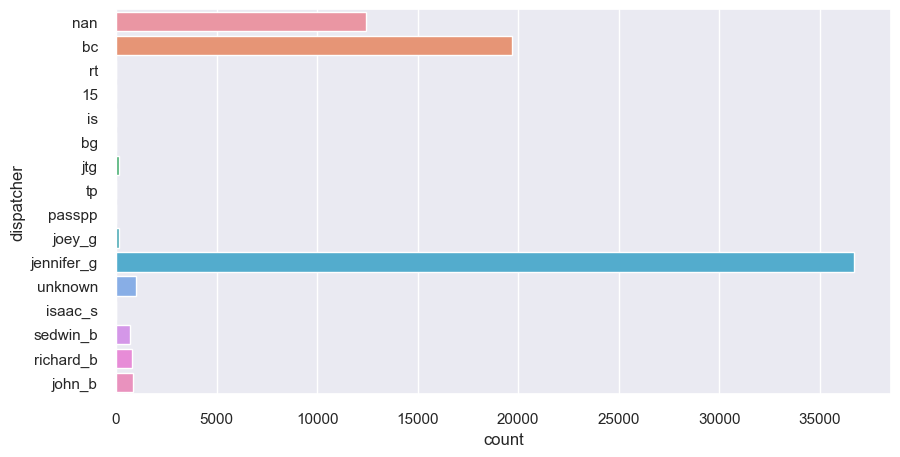

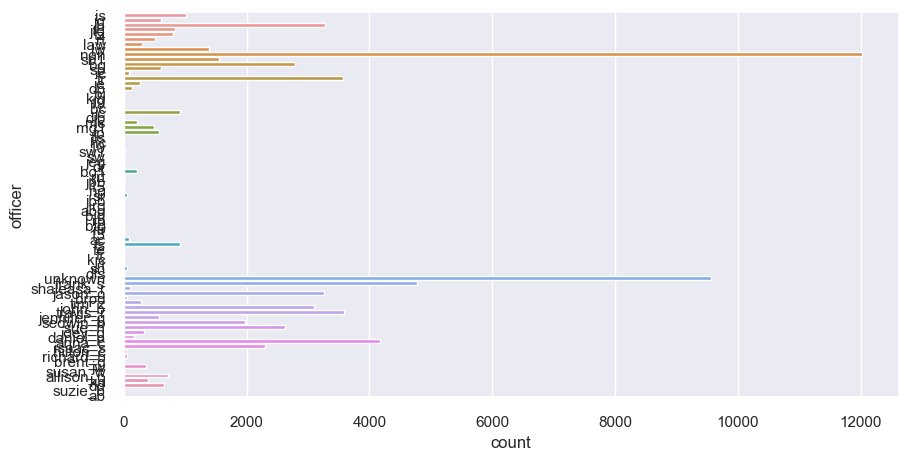

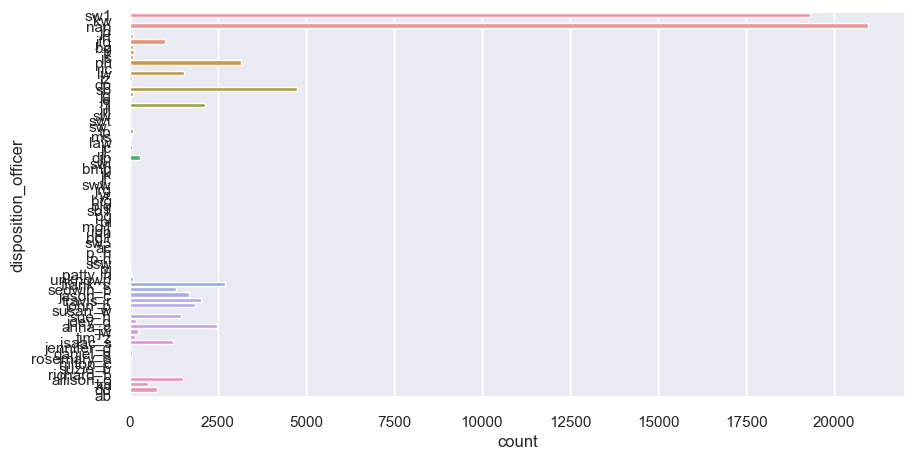

In [47]:
plot_counts(name_cols)

### location related

The features describing location are: municipality, location, zip code, and complainant street.

The only column without missing values is the street feature. The usefulness of this feature in analysis is questionable, but if enough correlation exists, I could use it to fill in missing data in one of the other features with the most likely value.

In [48]:
loc_cols = ('complainant_street','municipality', 'location', 'zip_code')

In [49]:
for col in loc_cols:
    print(df[col].value_counts(),'\n')

greenwell_springs_rd    662
airline_hw              651
plank_rd                518
florida_bl              516
jefferson_hw            496
lsu_pl                  386
perkins_rd              374
progress_rd             324
goodwood_bl             320
old_hammond_hw          302
highland_rd             281
prescott_rd             276
old_scenic_hw           267
scenic_hw               254
harrell's_ferry_rd      244
sherwood_forest_bl      241
tiger_bend_rd           234
victoria_dr             223
main_st                 193
hooper_rd               183
sherwood_st             175
o'neal_ln               170
blackwater_rd           169
evangeline_st           166
byron_st                160
flonacher_rd            159
flannery_rd             155
siegen_ln               155
fairfields_av           154
sherwood_forest_dr      153
                       ... 
jefferson_ave.            1
shoreline_av              1
ridgeview                 1
kenilworth                1
macon_dr            

complainant street has no nas, but not sure if it provides value to analysis without a region

In [50]:
#for col in loc_cols:
#    df.groupby(['complainant_street'])[col].value_counts().unstack().plot.bar(figsize=(14,7));

### animal features

#### color

In [51]:
#df.color.value_counts()
df.color.value_counts()

nan                        21526
blk                         4028
blk/wht                     3973
gry                         3212
brwn/wht                    1592
gry/wht                     1565
tan/wht                     1470
brwn                        1419
tan                         1417
blk/tan                     1296
gray                        1085
brown                       1053
grey                         929
gry/blk                      916
wht                          904
blk/gry                      789
blk/brwn                     762
brwn/blk                     754
wht/blk                      752
org                          719
black                        716
wht/brwn                     633
brn/blk                      615
brindle                      588
brn                          522
wht/tan                      512
tan/blk                      508
white                        388
wht/gry                      386
normal                       380
          

Color Feature Cleaning:

- Not liking the all caps, also unnecessary punctuation.


- 1089 unique color values is going to be a problem for machine learning models, so I'd also like to reduce those. Each color needs to have uniform spelling, and combinations with low value counts will be categorized as 'other' to reduce dimensionality and noise.

*_I'll be treating each combination as it's own category. I'm not sure if approaching each color as a separate feature would be practical, but maybe could be given more thought later. I don't see value in each individual color as much as the overall description of color(s) as a whole._

In [52]:
characters = ('_','/', '.', '//','\\', ',,', ',,,', '_/_')

edit_replace(characters, ',')

In [53]:
# looking at strings separated to evaluate how to edit; priority in high value counts

results = Counter()
df['color'].str.split(',').apply(results.update)
pp.pprint (results)

Counter({   'nan': 21526,
            'blk': 20144,
            'wht': 18319,
            'gry': 9291,
            'tan': 8470,
            'brwn': 6949,
            'brn': 3031,
            'gray': 2392,
            'white': 2294,
            'grey': 1997,
            'brown': 1979,
            'black': 1865,
            'org': 1490,
            'brindle': 1378,
            'red': 780,
            'yellow': 614,
            'blue': 587,
            'gold': 443,
            'normal': 380,
            'tabby': 360,
            'orange': 277,
            'calico': 250,
            'torti': 219,
            '': 184,
            'cream': 171,
            'tri': 125,
            'beige': 118,
            'choc': 112,
            'chocolate': 102,
            'multi': 92,
            'green': 90,
            'blonde': 85,
            'fawn': 67,
            'golden': 66,
            'spots': 64,
            'chest': 56,
            'wh': 55,
            'w': 52,
            'pink': 49,
     

In [54]:
#white: wht
whites = ('white', 'cream', 'whute', 'whit', 'whitg', 'wht','whtie', 'wwht', 'what')

edit_replace(whites, 'wht')

In [55]:
# blacks: bl
blacks = ('black', 'blk', 'blkl', 'charcoal', 'bllk', 'balck', 'blavk', 'bkl', 'vlack', 'blavck', 'blkc')

edit_replace(blacks, 'bk')

In [56]:
#browns: br
browns = ('brown', 'brwn', 'brn', 'choc', 'chocolate', 'brwon', 'choclate', 'brw', 'brownish', 'brow', 'brnlate', 'brnish', 'brnolate', 'brnm', 'brolate', 'brblk','chestnut', 'cho', 'brrwn')

edit_replace(browns,'br')

In [57]:
#greys: gry
greys = ('grey', 'gray', 'grrey', 'grey', 'gry')

edit_replace(greys, 'gry')

In [58]:
# tans/beige/blonde: tn
tans = ('beige', 'blonde', 'golden', 'tan\\', 'goldish', 'tna', 'gold', 'tan', 'taan', 'sandy')

edit_replace(tans, 'tn')

In [59]:
# stripes: stripe_tabby
tabbies = ('tabby','tiger', 'tabble', 'taddy', 'tabs', 'tabbie')

edit_replace(tabbies, 'tab')

In [60]:
# striped: strip
# edit_replace(('stripe'), 'strip')

In [61]:
#orange: or
oranges = ('orange','org', 'orn', 'copper', 'orang', 'orage')

edit_replace(oranges, 'or')

In [62]:
#brindle/fawn: brndl
brindles = ('brindle', 'fawn', 'merle', 'torti', 'marbled', 'tortie', 'bridle', 'brndl', 'brndle', 'brndlee','leopard', 'tortoise', 'brindlw', 'brindlde')

edit_replace(brindles, 'bndle')

In [63]:
#yellow: ylw
edit_replace(('yellow','yelow','yellw', 'yell'), 'ylw')

In [64]:
# stop words and not decribing color
to_drop = (',chest','and', 'normal')

edit_replace(to_drop, '')

In [65]:
# other and unknown in nan category
unknowns = ('other', 'unknown')

edit_replace(unknowns, 'nan')

In [66]:
#limiting colors to selected and also only with certain value count(no longer using this method)

#colors = ('wht', 'bk', 'gry', 'br', 'tn', 'spot', 'or', 'tab', 'blue', 'red', 'ylw', 'calico', 'tri', 'green', 'multi', 'dark', 'light', 'pink')

#ndf = df[~df['color'].isin([colors])]

#ndf = ndf[ndf.color.value_counts()>=20]

#ndf.color.value_counts()

In [67]:
# defining counts to separate at 20 value counts
counts = df['color'].value_counts()

In [68]:
# color combinations with less than 20 counts will be categorized as 'other'
other_color_df =df[df['color'].isin(counts[counts < 20].index)]

other_color_df['color'] = 'other'

/Users/Janelle/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [69]:
#should be one value: 'other'
other_color_df.color.value_counts()

other    2426
Name: color, dtype: int64

In [70]:
# color values with over/equal to n counts
colors_df =df[df['color'].isin(counts[counts >= 20].index)]

In [71]:
#should be n or more per value
colors_df.color.value_counts().tail()

gry,bk,br    21
br,tn,bk     21
bk,green     20
gry,tn,bk    20
br,red       20
Name: color, dtype: int64

In [72]:
#joining the 'other color' and 'all colors' dfs
ec_df = pd.concat([colors_df,other_color_df ])
len(ec_df)

72450

In [73]:
#all should have a minimum n value counts, 'other' should now be included
ec_df.color.value_counts()

nan           21568
gry            5226
bk,wht         4756
bk             4755
br             3115
other          2426
br,wht         2374
gry,wht        2273
tn,wht         1964
br,bk          1729
tn             1699
bk,tn          1672
gry,bk         1600
wht            1382
bk,gry         1297
bk,br          1114
wht,bk          899
wht,br          897
bndle           839
or              829
wht,tn          680
tn,bk           615
wht,gry         580
bndle,wht       498
gry,tn          493
or,wht          437
bk,br,wht       381
                380
ylw             379
gry,br          338
              ...  
tn,gry           52
br,tn,wht        51
br,bndle         51
br,tab           49
wht,tn,bk        47
bk,gry,tn        44
br,,bk           43
or,tab           37
br,ylw           33
or,bk            32
bk,red           28
gry,wht,bk       28
bk,tn,gry        28
gry,or           27
red,br           27
gry,pink         26
tn,gry,wht       26
green            25
gry,wht,tn       25


In [74]:
# quick check that all rows are still there
len(ec_df)

72450

In [75]:
# results = Counter()
# df['color'].str.split(',').apply(results.update)
# pp.pprint (results)

#### breed

In [76]:
df.breed.value_counts()

nan                               21001
dsh                               11440
possum                             5411
pitbull                            5363
raccoon                            4345
xpit_bull                          4232
xlabrador                          2807
xterrier                           1372
xshepherd                           938
pit                                 925
labrador_retriever                  911
dmh                                 827
german_shepherd                     780
terrier                             763
dlh                                 711
xgerman_shepherd                    614
xhound                              541
chihuahua                           447
squirrel                            400
xchihuahua                          374
horse                               351
other                               329
shih_tzu                            313
xrottweiler                         303
rottweiller                         294


In [77]:
# removing x. This could mean cross breed, but for the sake of dimension reducing, will be removed.
# may find it more beneficial to not remove in future work?

df['breed'] = df.breed.apply(lambda x: x.replace('x', ''))

In [78]:
sorted_breeds=df.sort_values('breed')
sorted_breeds.breed.unique()

array(['_german_shepherd', '_retriever', 'akita', 'alaskan__malamute',
       'american_bulldog', 'american_eskimo',
       'american_staffordshire_terrier', 'armadillo',
       'australian_blue_healer', 'australian_cattle',
       'australian_shepherd', 'basenji', 'basset', 'basset_hound', 'bat',
       'beagle', 'beaver', 'bichons_frise', 'bloodhound',
       'bluetick_hound', 'boer', 'border_collie', 'boston',
       'boston_terrier', 'bourvier_des_flanders', 'brittany',
       'brittany_spaniel', 'bull_mastiff', 'bull_terrier',
       'bulldog_(english)', 'bulldog_(french)', 'bulldog_english',
       'cairn_terrier', 'cane_corso', 'catahoula', 'catahoula_hound',
       'chicken', 'chihuahua', 'chinchilla', 'chow', 'chow_chow',
       'cocker_spaniel', 'collie', 'coonhound', 'cow', 'coyote', 'crow',
       'curr', 'dachshund', 'dalmation', 'dlh', 'dmh', 'doberman',
       'doberman_pinscher', 'donkey', 'dsh', 'duck_domestic',
       'english_bulldog', 'ferret', 'fish', 'fo_terrier',

In [79]:
#replacing alternate spellings of same breed
df = df.apply(lambda x: x.replace(' ', '_'))
df = df.apply(lambda x: x.replace('bulldog_(english)', 'bulldog_english'))
df = df.apply(lambda x: x.replace('chow_chow', 'chow'))
df = df.apply(lambda x: x.replace('boston_terrier', 'boston'))
df = df.apply(lambda x: x.replace('poodle_-standard', 'poodle'))
df = df.apply(lambda x: x.replace('basset_hound', 'basset'))
df = df.apply(lambda x: x.replace('rottweiller', 'rott'))
df = df.apply(lambda x: x.replace('rottweiler', 'rott'))
df = df.apply(lambda x: x.replace('pit_bull', 'pitbull'))
df = df.apply(lambda x: x.replace('pitbull', 'pit'))
df = df.apply(lambda x: x.replace('_german_shepherd', 'german_shepherd'))
df = df.apply(lambda x: x.replace('_retriever', 'retriever'))
df = df.apply(lambda x: x.replace('labrador_retriever', 'labrador'))
df = df.apply(lambda x: x.replace('poodle_(min/toy)', 'poodle_min/toy'))
df = df.apply(lambda x: x.replace('poodle_standard', 'poodle'))
df = df.apply(lambda x: x.replace('catahoula_hound', 'catahoula'))
df = df.apply(lambda x: x.replace('english_bulldog', 'bulldog_english'))
df = df.apply(lambda x: x.replace('bulldog_(french)', 'bulldog_french'))
df = df.apply(lambda x: x.replace('boer', 'boxer'))
df = df.apply(lambda x: x.replace('fo_terrier', 'fox_terrier'))
df = df.apply(lambda x: x.replace('shar_pei', 'sharpei'))
df = df.apply(lambda x: x.replace('alaskan__malamute','alaskan_malamute'))
df = df.apply(lambda x: x.replace('brittany_spaniel', 'brittany'))
df = df.apply(lambda x: x.replace('fohound', 'foxhound'))
# def replace_breed(old, replaced, df=df):
#     df = df.apply(lambda x: x.replace(old,replaced))

# replace_breed('rottweiller', 'rottweiler')
# replace_breed('rotweiler', 'rott')
# replace_breed('pit_bull', 'pitbull')
# replace_breed('pitbull', 'pit')
# replace_breed('_german_shepherd', 'german_shepherd')
# replace_breed('labroador_retriever', 'labrador')
# replace_breed('poodle_(min/toy)', 'poodle_min/toy')
# replace_breed('poodle_standard', 'poodle')


In [80]:
# has unique values been reduced?
len(df.breed.value_counts())

139

In [81]:
#letter_count = collections.Counter("alphabet")
results = Counter()
df['breed'].str.split(',').apply(results.update)
pp.pprint (results)

Counter({   'nan': 21001,
            'dsh': 11440,
            'pit': 10520,
            'possum': 5411,
            'raccoon': 4345,
            'labrador': 3718,
            'terrier': 2135,
            'german_shepherd': 1548,
            'shepherd': 1027,
            'dmh': 827,
            'chihuahua': 821,
            'dlh': 711,
            'hound': 663,
            'rott': 597,
            'boxer': 442,
            'squirrel': 400,
            'horse': 351,
            'beagle': 339,
            'other': 329,
            'catahoula': 324,
            'chow': 320,
            'shih_tzu': 313,
            'armadillo': 285,
            'dachshund': 244,
            'retriever': 239,
            'mied': 230,
            'husky': 194,
            'yorkshire_terrier': 177,
            'american_bulldog': 162,
            'snake_domestic_non_poisonous': 158,
            'bat': 154,
            'siamese': 145,
            'poodle': 137,
            'australian_shepherd': 134,
        

In [82]:
dogs = ('pit', 'labrador', 'terrier', 'german_shepherd', 'shepherd', 'chihuahua', 'hound', 'rott'
        , 'boxer', 'beagle', 'catahoula', 'chow', 'shih_tzu', 'dachshund', 'retriever', 'husky'
        , 'yorkshire_terrier', 'american_bulldog', 'poodle', 'australian_shepherd', 'poodle_min/toy'
        , 'collie', 'pomeranian', 'mastiff', 'golden_retriever', 'maltese', 'cocker_spaniel', 'healer'
        , 'doberman_pinscher', 'miniature_pinscher', 'border_collie', 'schnauzer', 'great_dane'
        , 'rat_terrier', 'akita', 'jack_russel_terrier', 'bulldog_english', 'spaniel', 'doberman'
        , 'pug', 'pekingese', 'basset', 'dalmation', 'boston', 'weimeraner', 'lhasa_apso', 'pointer'
        , 'rhodesian_ridgeback', 'sharpei', 'great_pyrenees', 'bull_terrier', 'bichons_frise', 'bloodhound'
        , 'saint_bernard', 'springer_spaniel', 'sheepdog', 'alaskan_malamute', 'scottish_terrier'
        , 'cairn_terrier', 'staffordshire_bull_terrier', 'setter', 'sheltie', 'cane_corso', 'whippet'
        ,  'basenji', 'spitz', 'greyhound', 'walker_hound', 'siberian_husky', 'west_highland_terrier'
        , 'american_eskimo', 'bull_mastiff', 'brittany', 'bluetick_hound', 'foxhound', 'australian_cattle'
        , 'american_staffordshire_terrier', 'bulldog_french', 'australian_blue_heeler', 'bourvier_des_flanders'
        , 'fox_terrier', 'wolf', 'coonhound', 'norweigian_elkhound')

#### condition, temperment, size

In [83]:
#value counts of species, size, condition, and temperment features
ssct_df = df[['species', 'size', 'condition', 'temperment', 'disposition']]

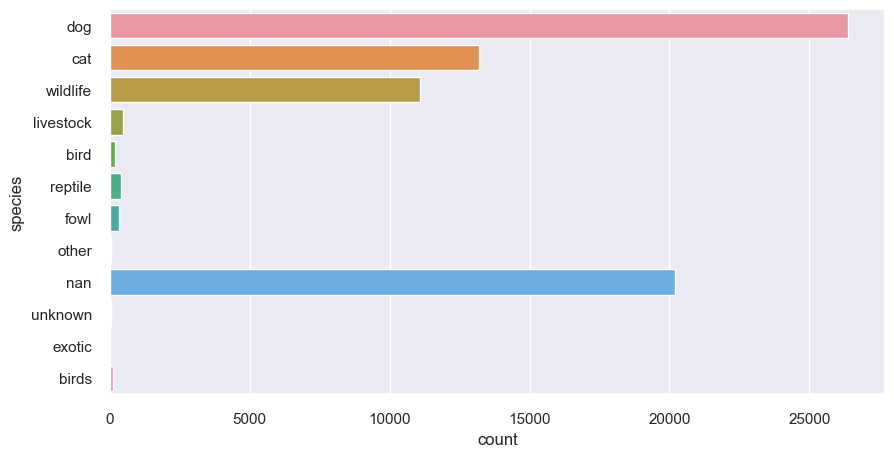

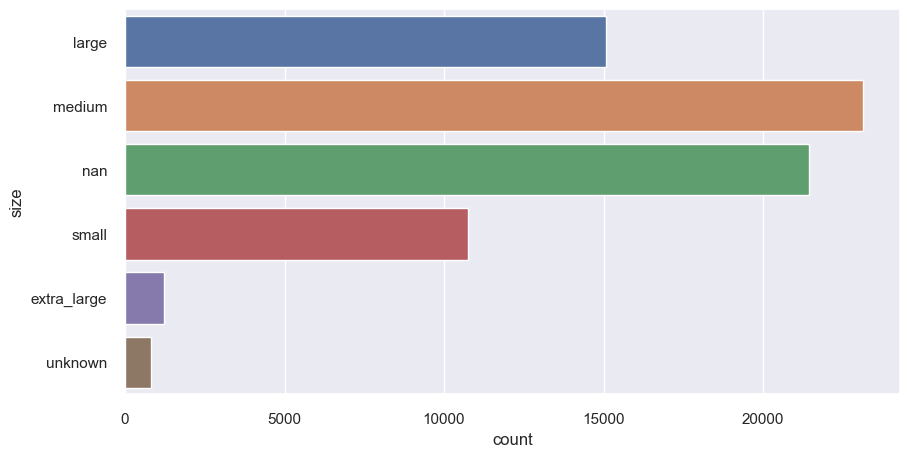

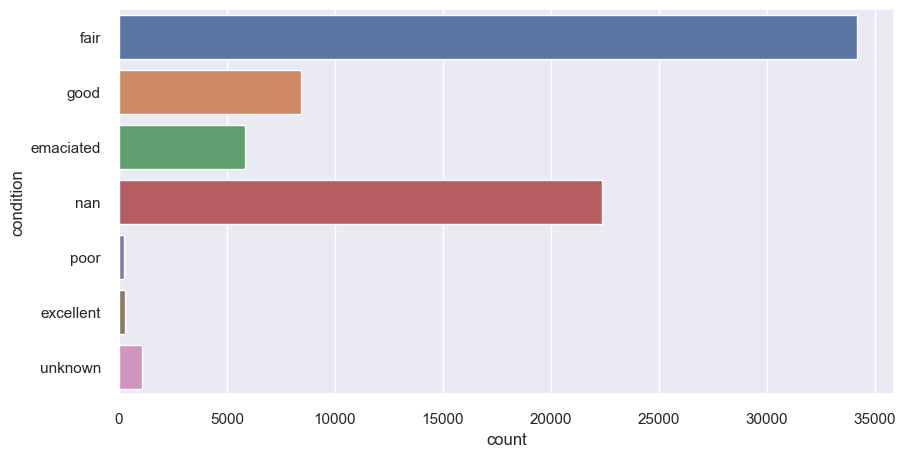

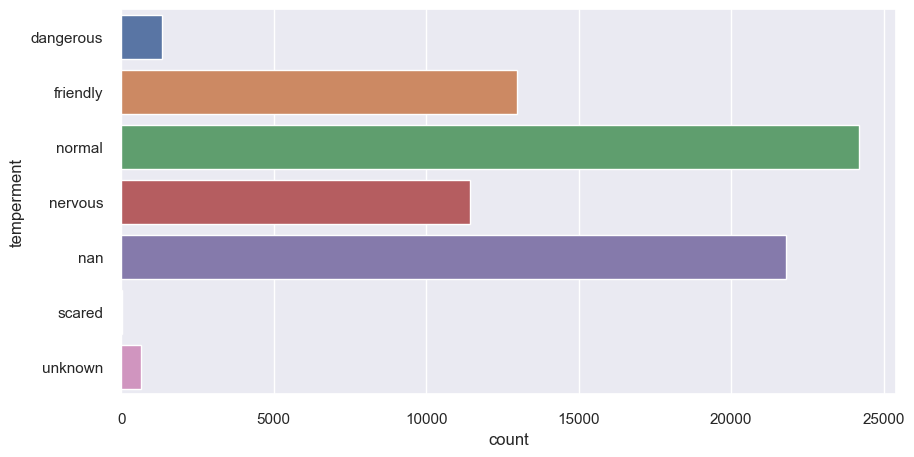

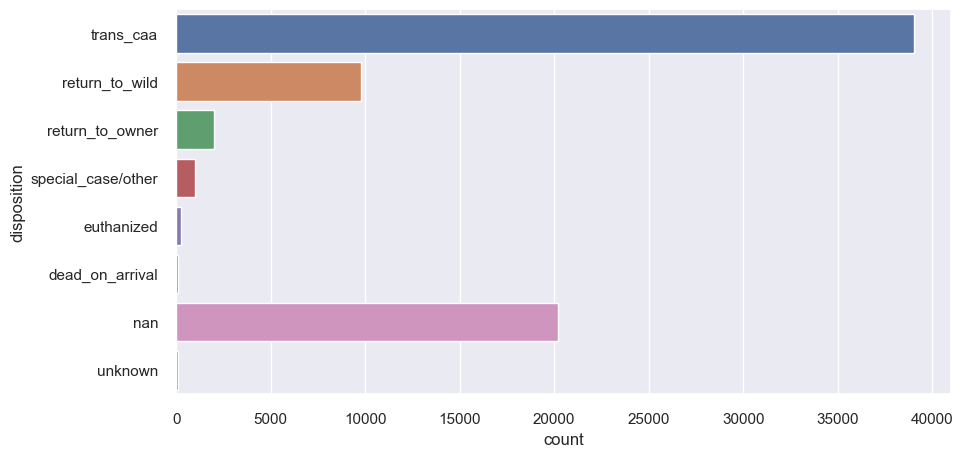

In [84]:
plot_counts(ssct_df)

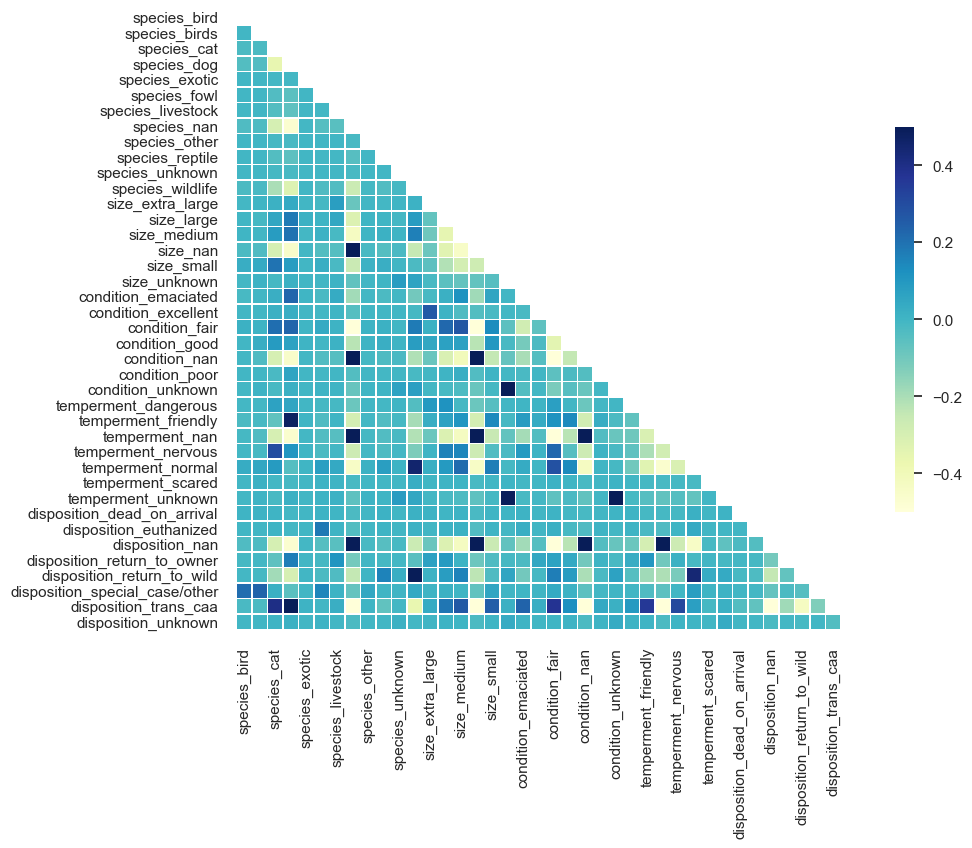

In [85]:
# correlations between species, size, condition, and temperment
corr_plot(ssct_df, -.5, .5)

#

In [86]:
# drop rows with any unknowns
#df = df[~df.eq('unknown').any(1)]

In [87]:
len(df)

72450

In [88]:
df.condition.value_counts()

fair         34191
nan          22397
good          8432
emaciated     5835
unknown       1056
excellent      294
poor           245
Name: condition, dtype: int64

In [89]:
df.temperment.value_counts()

normal       24205
nan          21792
friendly     12989
nervous      11423
dangerous     1350
unknown        664
scared          27
Name: temperment, dtype: int64

In [90]:
df['size'].value_counts()

medium         23143
nan            21452
large          15081
small          10738
extra_large     1235
unknown          801
Name: size, dtype: int64

In [91]:
#cts_df = df[['condition', 'temperment', 'size']]

#corr_plot(cts_df, -.3, .3)

### incident features

In [92]:
df.service_type.value_counts()

trapped_animal                17894
stray                         10229
unknown                        4979
stray_an._secured              4868
stray_an_secured               3119
loose                          2711
owner_signed_release           2264
injured                        1975
abandoned_animal               1883
loose_animal                   1552
cruelty_case                   1439
animal_rescue                  1333
unit_standing_by               1333
wild_live                      1295
cruelty                        1138
delivered_tags                 1065
other                           953
bite_case_loose                 929
sick_animal                     879
vet_pickup                      793
pick_up_trap                    784
bite_case                       771
special_case                    680
snake                           675
patrol_area                     654
pit                             618
cruelty_recheck                 509
deliver_trap                

In [93]:
#df['service_type']=df['service_code'].mask(pd.isnull, df['request_type'])

In [94]:
df['service_type'] = df['service_type'].apply(lambda x: x.replace('stray_an._secured', 'stray_an_secured'))
df['service_type'] = df['service_type'].apply(lambda x: x.replace('dangerous_animal_sit.', 'dangerous_animal_sit'))

#### equipment number

In [95]:
df.equipment_number.value_counts()

nan      12665
ac04      6331
ac12      6075
ac09      6038
ac13      5547
ac10      4864
ac06      4773
ac11      4596
ac19      4410
ac01      3758
ac18      3713
ac16      3483
ac15      2818
ac14      1646
ac20       229
19         130
12         116
15          87
ac9         83
4           79
11          79
ac6         76
10          69
14          69
13          65
09          58
ac4         54
9           47
ac05        44
1           42
         ...  
06          17
ac_10       16
ac_4        15
04          14
ac_1        12
ac_9        10
ac08        10
ac_6         8
ac_18        7
ac_8         6
ac_13        6
18           4
ac_14        4
17           3
ac_20        3
ac-14        3
5            3
ac_12        3
ac5          2
ac-4         2
ac198        1
ac016        1
ac-_4        1
zac14        1
2692         1
ac_7         1
ac-10        1
ac_15        1
4c18         1
sc           1
Name: equipment_number, Length: 68, dtype: int64

In [96]:
#df.groupby(['zip_code'])['municipality_'].value_counts().unstack().plot.bar(figsize=(14,7));